In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as smt # for ccf 
from statsmodels.stats.diagnostic import compare_j # J-test
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

## Data imports

# Macro study of the HK listed equities market

### Macroeconomic indicators / exogenous variables

Data frequency is daily, monthly or quarterly. I will regress the daily indicators against daily returns of the HKEX / sectors and repeat similarly for other time frames. 

In [2]:
AUDUSD = pd.read_csv('data/AUD_USD.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
AUDCNY = pd.read_csv('data/AUD_CNY.csv', index_col=0, parse_dates=True, infer_datetime_format=True)

CAIXIN = pd.read_csv('data/Caixin_PMI.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
CN10Y = pd.read_csv('data/CN_10Y.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
CN_GDP = pd.read_csv('data/CN_nominal_GDP.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
CN_CPI = pd.read_csv('data/CN_10Y.csv', index_col=0, parse_dates=True, infer_datetime_format=True)

US10Y = pd.read_csv('data/US_10Y.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
DXY = pd.read_csv('data/DXY.csv', index_col=0, parse_dates=True, infer_datetime_format=True)

### Quarterly comparisons to do
- CAIXIN, CN_GDP, US_GDP vs HK50 (indexed monthly)

### Daily comparisons to do
- AUDUSD, AUDCNY, DXY, CN10Y/US10Y differential (adjusted for inflation i.e. real rates) vs HK50 (indexed daily)
- each of the individual HSC indices vs HK50 overall. 

In [3]:
DXY.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2000-01-07,100.80,100.49,100.93,100.44,NaN,0.15%
2000-01-06,100.65,100.31,100.81,99.81,NaN,0.27%
2000-01-05,100.38,100.42,100.47,99.71,NaN,-0.03%
2000-01-04,100.41,100.55,100.86,100.01,NaN,0.19%
2000-01-03,100.22,101.67,101.83,100.19,NaN,-1.62%


Import HKEX / sector indices

In [4]:
HK50 = pd.read_csv('data/HS/HK50.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCC = pd.read_csv('data/HS/HSCC.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCE = pd.read_csv('data/HS/HSCE.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIC = pd.read_csv('data/HS/HSCIC.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCICD = pd.read_csv('data/HS/HSCICD.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCICS = pd.read_csv('data/HS/HSCICS.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIE = pd.read_csv('data/HS/HSCIE.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIF = pd.read_csv('data/HS/HSCIF.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIH = pd.read_csv('data/HS/HSCIH.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIIG = pd.read_csv('data/HS/HSCIIG.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIIT = pd.read_csv('data/HS/HSCIIT.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIM = pd.read_csv('data/HS/HSCIM.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIPC = pd.read_csv('data/HS/HSCIPC.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIT = pd.read_csv('data/HS/HSCIT.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSCIU = pd.read_csv('data/HS/HSCIU.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')

In [5]:
# create a dataframe containing HSI, first put the above into a dictionary for easy iteration

HSI_dict = {"HSCC": HSCC,
            "HSCE": HSCE,
            "HSCIC": HSCIC,
            "HSCICD": HSCICD,
            "HSCICS": HSCICS,
            "HSCIE": HSCIE,
            "HSCIE": HSCIE,
            "HSCIF": HSCIF,
            "HSCIH": HSCIH,
            "HSCIIG": HSCIIG,
            "HSCIIT": HSCIIT,
            "HSCIM": HSCIM,
            "HSCIPC": HSCIPC,
            "HSCIT": HSCIT,
            "HSCIU": HSCIU}

HSI_df = pd.DataFrame()

for ind in HSI_dict.keys():
    HSI_df = pd.concat([HSI_df, HSI_dict[ind]['Price']], axis=1)
    
HSI_df.columns = HSI_dict.keys()

In [6]:
# calculate sector index returns

HSI_returns_df =  np.log(HSI_df.dropna()) - np.log(HSI_df.dropna().shift(-1))

In [7]:
HSI_returns_df

,HSCC,HSCE,HSCIC,HSCICD,HSCICS,HSCIE,HSCIF,HSCIH,HSCIIG,HSCIIT,HSCIM,HSCIPC,HSCIT,HSCIU
2023-02-08,0.010649,-0.005958,0.014369,0.000062,-0.000140,0.007876,0.008265,-0.001266,0.001760,-0.014428,0.002442,0.006548,-0.003446,0.011128
2023-02-07,0.003958,0.005947,-0.003749,0.000337,-0.002919,0.012551,0.002230,0.007524,-0.001950,0.009034,0.007440,0.001699,-0.003116,0.001278
2023-02-06,-0.013832,-0.027121,-0.012363,-0.030311,-0.016533,-0.009576,-0.008704,-0.048956,-0.033097,-0.030508,-0.039940,-0.025736,-0.004875,-0.008257
2023-02-03,-0.013061,-0.015950,-0.017748,-0.010060,-0.013519,-0.023865,-0.016143,-0.015145,-0.013414,-0.009747,-0.021555,-0.008346,-0.000883,-0.007083
2023-02-02,-0.009237,-0.007249,-0.011150,-0.006160,0.001774,-0.002007,-0.006936,0.015662,-0.007124,-0.005774,-0.009322,-0.008289,0.000835,0.000679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-16,0.005239,-0.005583,-0.013457,-0.014020,-0.004171,0.036987,-0.010595,-0.005186,-0.004240,-0.008641,0.000300,-0.011050,-0.005887,-0.004659
2019-09-13,0.007474,0.008964,0.001008,0.019108,0.008152,0.006495,0.011142,0.007242,0.013390,0.004335,0.017621,0.013484,0.003505,0.008194
2019-09-12,0.000133,0.002586,-0.000803,0.007008,0.009571,-0.017801,-0.004690,0.010091,0.008404,0.011164,0.002103,0.000022,0.002105,0.004331
2019-09-11,0.008655,0.015421,0.016617,0.004320,0.004949,0.015119,0.021204,-0.017092,0.005237,0.013645,0.021033,0.016869,0.008893,0.008951


In [8]:
# test code for ccf analysis on HSCC / HK50. Look at lag over entire dataset (shortest of exo/endo variable) and also different time periods. 
# looks like I'm indexing by day so 5 days, 20 days, 60 days

HSI_returns_df['HSCC']

2023-02-08    0.010649
2023-02-07    0.003958
2023-02-06   -0.013832
2023-02-03   -0.013061
2023-02-02   -0.009237
                ...   
2019-09-16    0.005239
2019-09-13    0.007474
2019-09-12    0.000133
2019-09-11    0.008655
2019-09-10         NaN
Name: HSCC, Length: 831, dtype: float64

In [9]:
HK50['Return'] = np.log(HK50['Price']) - np.log(HK50['Price'].shift(-1))
HK50 = HK50.dropna()

In [10]:
def get_shortest_array(a,b):
    '''
    input - a,b arrays (pandas.values) arrays
    output - returns length of shortest array using first index of np.shape
    '''
    
    len_a = np.shape(a)[0]
    len_b = np.shape(b)[0]
    
    return min(len_a,len_b)

In [11]:
get_shortest_array(HK50['Return'],HSI_returns_df['HSCC'])

831

In [12]:
len(HK50['Return'])

2829

In [13]:
len(HSI_returns_df['HSCC'])

831

In [14]:
HK50['Return'].iloc[:831].tail()

Date
2019-09-26    0.003716
2019-09-25   -0.012854
2019-09-24    0.002232
2019-09-23   -0.008100
2019-09-20   -0.001258
Name: Return, dtype: float64

In [15]:
HSI_returns_df['HSCC'].tail()

2019-09-16 00:00:00    0.005239
2019-09-13 00:00:00    0.007474
2019-09-12 00:00:00    0.000133
2019-09-11 00:00:00    0.008655
2019-09-10 00:00:00         NaN
Name: HSCC, dtype: float64

In [16]:
# perform ccf on entire dataset

def calc_ccf(a,b,title):
    '''
    For arrays a, b run statsmodesl ccf.
    input - a,b as pandas df, not values
    To do: extra argument for window which will then return another time series. Maybe only relevant for correlation / cointegration? 
    '''
    
    len_shortest_array = get_shortest_array(a,b)
    
    ccf_output = smt.ccf(a.iloc[:len_shortest_array],b.iloc[:len_shortest_array], adjusted=False)
    
    plt.stem(range(len(ccf_output)), ccf_output)
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('CCF')
    # 95% UCL / LCL
    plt.axhline(-1.96/np.sqrt(len_shortest_array), color='k', ls='--') 
    plt.axhline(1.96/np.sqrt(len_shortest_array), color='k', ls='--')
    
    

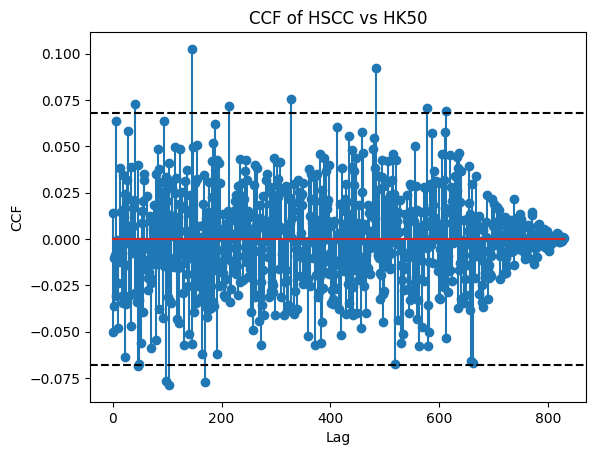

In [17]:
calc_ccf(HSI_returns_df['HSCC'].dropna(),HK50['Return'].dropna(), 'CCF of HSCC vs HK50')

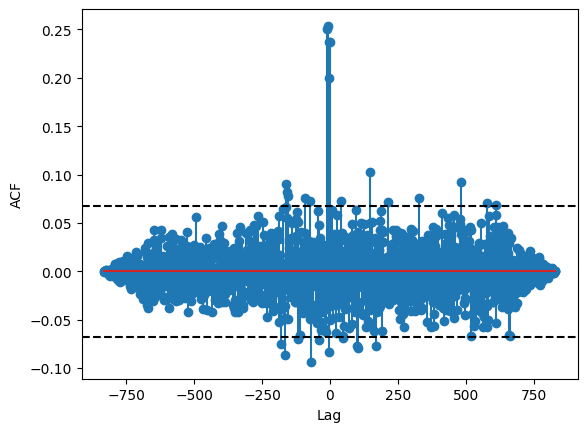

In [18]:
# test code from: https://stackoverflow.com/questions/63491991/how-to-use-the-ccf-method-in-the-statsmodels-library#63496864 
# evaulate ccf with both positive and negative lags
# ccf_output = smt.ccf(HSI_returns_df['HSCC'].dropna(),HK50['Return'].iloc[:831].dropna(), adjusted=False)
backwards = smt.ccf(HSI_returns_df['HSCC'].dropna()[::-1], HK50['Return'].iloc[:831].dropna()[::-1], adjusted=False)[::-1]
forwards = smt.ccf(HSI_returns_df['HSCC'].dropna(), HK50['Return'].iloc[:831].dropna(), adjusted=False)
ccf_output = np.r_[backwards[:-1], forwards]


plt.stem(range(-len(ccf_output)//2, len(ccf_output)//2), ccf_output)
plt.xlabel('Lag')
plt.ylabel('ACF')
# 95% UCL / LCL
plt.axhline(-1.96/np.sqrt(831), color='k', ls='--') 
plt.axhline(1.96/np.sqrt(831), color='k', ls='--') # replace 831 with length of shortest array

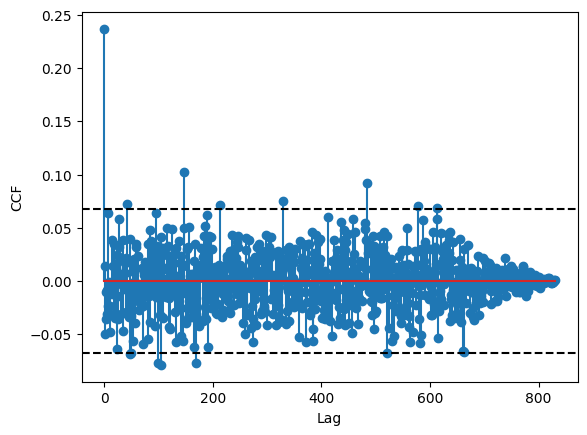

In [19]:
ccf_output = smt.ccf(HSI_returns_df['HSCC'].dropna(),HK50['Return'].iloc[:831].dropna(), adjusted=False)
plt.stem(range(len(ccf_output)), ccf_output)
plt.xlabel('Lag')
plt.ylabel('CCF')
# 95% UCL / LCL
plt.axhline(-1.96/np.sqrt(831), color='k', ls='--') 
plt.axhline(1.96/np.sqrt(831), color='k', ls='--') # replace 831 with length of shortest array

### Correlation analysis

In [20]:
get_shortest_array(HK50['Return'],HSI_returns_df['HSCC'])

831

In [38]:
def plot_cor(x, y, window, filename, x_name, y_name):
    '''
    x (df) - first time series
    y (df) - second time series
    window (int) - period length
    filename - output filename as .png
    x_name - first time series name (for title)
    y_name - second time series name (for title)
    Note that x and y don't have to be the same length. the 'get_shortest_array' function will be used to automatically trim the time series
    '''
    shortest_time_series_len = get_shortest_array(x,y)
    plt.plot(x.iloc[:shortest_time_series_len].dropna().rolling(window).corr(y.iloc[:shortest_time_series_len].dropna()));
    
    # rotate x-axis labels so date labels all fit in properly
    plt.xticks(rotation=90);
    plt.title('20-day rolling correlation between '+str(x_name)+ ' and '+str(y_name))
    plt.savefig(str(filename),dpi=600)


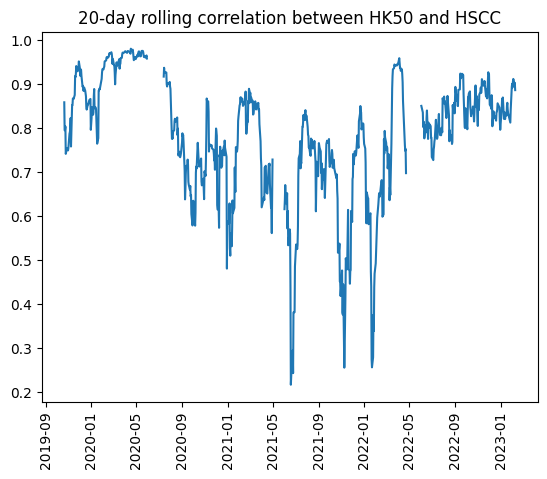

In [39]:
# same code as cell below but using function

plot_cor(HK50['Return'], HSI_returns_df['HSCC'], 20, "HK50_HSCC_20corr.png", "HK50", "HSCC")

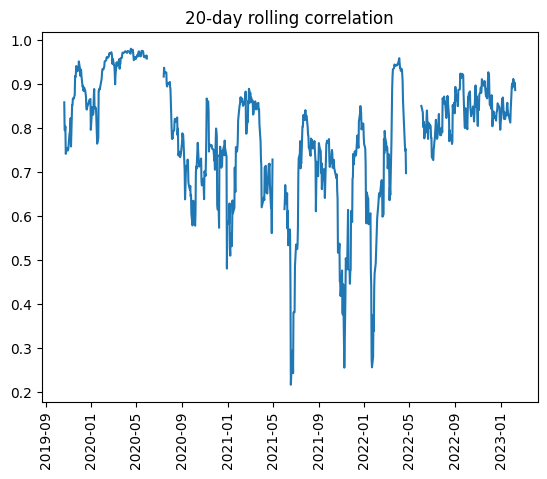

In [37]:
# test code, it has been "functionalised" see above
shortest_HK50_HSI = get_shortest_array(HK50['Return'],HSI_returns_df['HSCC'])

plt.plot(HK50['Return'].iloc[:shortest_HK50_HSI].dropna().rolling(20).corr(HSI_returns_df['HSCC'].iloc[:shortest_HK50_HSI].dropna()));
plt.xticks(rotation=90);
plt.title('20-day rolling correlation');
plt.savefig('test.png',dpi=600)

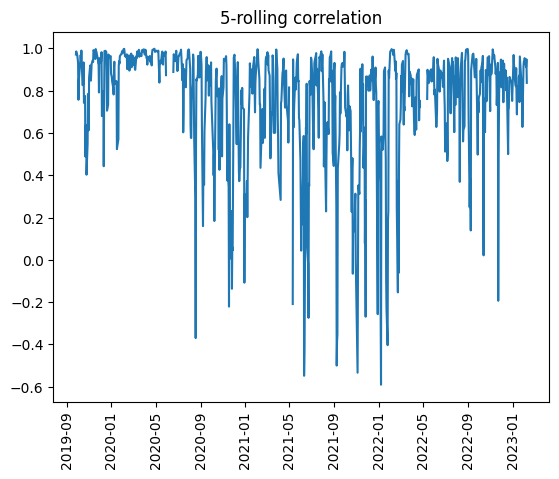

In [33]:
shortest_HK50_HSI = get_shortest_array(HK50['Return'],HSI_returns_df['HSCC'])

plt.plot(HK50['Return'].iloc[:shortest_HK50_HSI].dropna().rolling(5).corr(HSI_returns_df['HSCC'].iloc[:shortest_HK50_HSI].dropna()));
plt.xticks(rotation=90);
plt.title('5-rolling correlation');

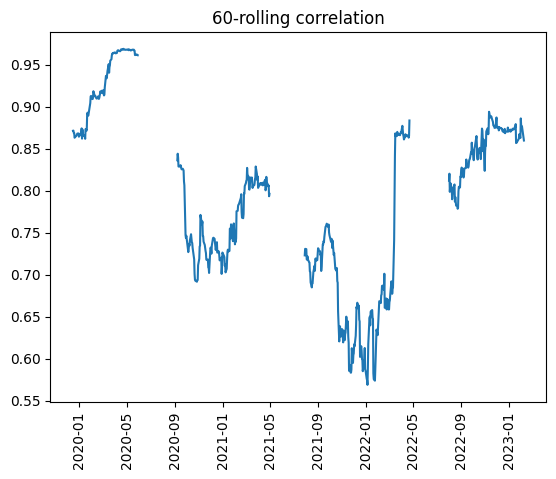

In [34]:
shortest_HK50_HSI = get_shortest_array(HK50['Return'],HSI_returns_df['HSCC'])

plt.plot(HK50['Return'].iloc[:shortest_HK50_HSI].dropna().rolling(60).corr(HSI_returns_df['HSCC'].iloc[:shortest_HK50_HSI].dropna()));
plt.xticks(rotation=90);
plt.title('60-rolling correlation');

In [46]:
HSI_df.dropna().to_csv('HSI_df.csv')

In [58]:
# Try reading in df hopefully it solves the string problem
HSI_df_test = pd.read_csv('HSI_df.csv', index_col=0, parse_dates=True, infer_datetime_format=True,thousands=',')

In [60]:
HSI_df_test.astype(float)

,HSCC,HSCE,HSCIC,HSCICD,HSCICS,HSCIE,HSCIF,HSCIH,HSCIIG,HSCIIT,HSCIM,HSCIPC,HSCIT,HSCIU
2023-02-08,3947.90,7189.29,1598.90,3055.36,20975.94,8342.66,3376.48,13641.62,1262.72,11841.00,6710.50,2442.35,1219.63,5844.62
2023-02-07,3906.08,7232.25,1576.09,3055.17,20978.88,8277.21,3348.69,13658.90,1260.50,12013.08,6694.13,2426.41,1223.84,5779.94
2023-02-06,3890.65,7189.37,1582.01,3054.14,21040.21,8173.97,3341.23,13556.51,1262.96,11905.04,6644.51,2422.29,1227.66,5772.56
2023-02-03,3944.84,7387.02,1601.69,3148.13,21390.96,8252.62,3370.44,14236.69,1305.46,12273.84,6915.26,2485.44,1233.66,5820.42
2023-02-02,3996.70,7505.79,1630.37,3179.96,21682.10,8451.94,3425.29,14453.95,1323.09,12394.06,7065.94,2506.27,1234.75,5861.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-16,4334.71,10628.25,2164.11,2740.41,22708.88,8288.62,3764.96,14128.45,1313.19,11112.39,4599.73,4020.08,1551.41,7396.02
2019-09-13,4312.06,10687.75,2193.43,2779.10,22803.80,7987.65,3805.06,14201.91,1318.77,11208.83,4598.35,4064.75,1560.57,7430.56
2019-09-12,4279.95,10592.37,2191.22,2726.50,22618.65,7935.94,3762.90,14099.43,1301.23,11160.35,4518.03,4010.31,1555.11,7369.92
2019-09-11,4279.38,10565.01,2192.98,2707.46,22403.19,8078.47,3780.59,13957.87,1290.34,11036.45,4508.54,4010.22,1551.84,7338.07


Test code / failed

In [54]:
HSI_df_test = HSI_df.dropna()
HSI_df_test = HSI_df_test.astype(float)

ValueError: could not convert string to float: '3,055.36'

In [52]:
HSI_df.dropna().head().pct_change()

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [35]:
HSI_returns_df =  np.log(HSI_df.dropna()) - np.log(HSI_df.dropna().shift(-1))

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log method

In [25]:
HSI_dict.keys()

dict_keys(['HSCC', 'HSCE', 'HSCIC', 'HSCICD', 'HSCICS', 'HSCIE', 'HSCIF', 'HSCIH', 'HSCIIG', 'HSCIIT', 'HSCIM', 'HSCIPC', 'HSCIT', 'HSCIU'])

In [21]:
test_df

,Price,Price
Date,,
2000-12-05,14573.21,1669.56
2000-12-06,15098.95,1735.00
2000-12-07,15011.52,1723.16
2000-12-08,15189.33,1713.78
2000-12-11,15408.54,1702.95
...,...,...
2023-02-06,21222.16,3890.65
2023-02-07,21298.70,3906.08
2023-02-08,21283.52,3947.90


In [10]:
HK50['Price']/HK50['Price'].shift(-1)


Date
2023-02-10    21234.00
2023-02-09    21624.36
2023-02-08    21283.52
2023-02-07    21298.70
2023-02-06    21222.16
                ...   
2000-12-11    15408.54
2000-12-08    15189.33
2000-12-07    15011.52
2000-12-06    15098.95
2000-12-05    14573.21
Name: Price, Length: 5496, dtype: float64

In [ ]:
log_returns_ETFs = np.log(data) - np.log(data.shift(1))

In [12]:
def log_returns(dataframe):
    '''
    input - dataframe obtained from investing.com containing a 'Price' column
    output - log returns as dataframe using same datetime index
    '''
    
    return np.log(dataframe['Price']/dataframe['Price'].shift(-1))

If NaNs are present in the data, we should put a number to fix that. To prevent look-ahead bias, we used the fill-forward method and assume that it doesn't introduce extra issues associated with data granularity.

In [15]:
log_returns(HK50)

Date
2023-02-10   -0.018217
2023-02-09    0.015887
2023-02-08   -0.000713
2023-02-07    0.003600
2023-02-06   -0.020443
                ...   
2000-12-11    0.014329
2000-12-08    0.011775
2000-12-07   -0.005807
2000-12-06    0.035440
2000-12-05         NaN
Name: Price, Length: 5496, dtype: float64

In [ ]:
scaled_leading = StandardScaler().fit_transform(leading_monthly)

for etf in _11_SPDR_ETFs:
    # another modification to our original code with Sklearn, I've added a column of ones so a constant term
    # is added to our regression model. This is done using the sm.add_constant keyword. 
    X = scaled_leading * np.array(LEI_weigths)
    X = sm.add_constant(X)
    y = np.array([log_returns_ETFs[etf].fillna(0).resample('1M').mean()]).reshape(-1,1)

    # careful because sm.OLS reverses the order of endogenous/exogenous variables compared to sklearn.
    regression_leading[etf] = sm.OLS(y, X).fit() 

data processing: create a function that computes returns for relevant time series. How to deal with quarterly-indexed time series? Maybe to compare, I'll need code to reindex the daily time series.

To obtain a better understand of the macroeconomic dependence of the HK market, we will perform linear regression on a variety of indicators. And for each HKEX sector. Regression window will be 1M, 3M and 6M to identify regime changes over time.